In [24]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer

In [2]:
dataset = pd.read_csv('../db/AmesHousing.csv', sep='\t')
localCopy=dataset.copy(deep=True)

In [3]:
#SEPARATION OF CATEGORICAL AND NUMERICAL FEATURES

#AmesExplanations.txt indicates a separation of the data in 4 types:
# Continuous - numerical
# Nominal - categorical
# Ordinal - usually categorical, numerical if order matters
# Discrete - usually numerical, categorical if it's an ID

cat_features = ['MS SubClass','MS Zoning','Street','Alley',
                'Lot Shape','Land Contour','Utilities','Lot Config',
                'Land Slope','Neighborhood','Condition 1','Condition 2',
                'Bldg Type','House Style','Roof Style','Roof Matl',
                'Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation',
                'Heating','Central Air','Electrical','Garage Type',
                'Paved Drive','Misc Feature','Sale Condition']

num_features = ['Lot Frontage','Lot Area','Overall Qual','Overall Cond',
                'Year Built','Year Remod/Add','Mas Vnr Area','Exter Qual',
                'Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure',
                'BsmtFin Type 1', 'BsmtFin SF 1','BsmtFin Type 2','BsmtFin SF 2',
                'Bsmt Unf SF','Total Bsmt SF','Heating QC','1st Flr SF','2nd Flr SF',
                'Low Qual Fin SF','Gr Liv Area','Bsmt Full Bath','Bsmt Half Bath',
                'Full Bath','Half Bath','Bedroom','Kitchen','Kitchen Qual','TotRmsAbvGrd',
                'Functional','Fireplaces','Fireplace Qu',
                'Garage Yr Blt','Garage Finish','Garage Cars','Garage Area','Garage Qual',
                'Garage Cond','Wood Deck SF','Open Porch SF','Enclosed Porch','3-Ssn Porch',
                'Screen Porch','Pool Area','Pool QC','Fence','Misc Val','Mo Sold','Yr Sold',
                'Sale Type']


# Features that describe a grade (ex. Quality: 1-10 or Poor/Average/Excellent) will be treated as
# numeric values. There are string values as well; these will be mapped to numbers so that the model
# understands them

# to be mapped to numbers: Exter Qual, Exter Cond, Bsmt Qual, Bsmt Cond, Bsmt Exposure,
# BsmtFin Type 1, BsmtFinType 2, HeatingQC, KitchenQual, Functional, FireplaceQu, 
# Garage Finish, Garage Qual, Garage Cond, Pool QC, Fence, Sale Type

ordinal_maps = {'Exter Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Exter Cond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Bsmt Qual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Bsmt Cond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Bsmt Exposure': {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
                'BsmtFin Type 1': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
                'BsmtFin Type 2': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
                'Heating QC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Kitchen Qual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Functional': {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8},
                'Fireplace Qu': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Garage Finish': {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3},
                'Garage Qual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Garage Cond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                'Pool QC': {'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
                'Fence': {'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4},
                'Sale Type': {'Oth':1, 'ConLD':2, 'ConLI':3, 'ConLw':4, 'Con':5, 'COD':6, 'New':7, 'VWD':8, 'CWD':9, 'WD':10}
                }

# apply the mappings to the strings
for col,mapping in ordinal_maps.items():
    if col in localCopy.columns:
        localCopy[col] = localCopy[col].map(mapping)

In [4]:
#FEATURE ENGINEERING: Deletion

#dropping the PID , Order Column
# Yr Sold, Sale Price, Year Built, Total Bsmt SF, Gr Liv Area because they have a high correlation with 
# other features, we are gonna keep them and delete the others
localCopy.drop(columns=['PID','Order','Overall Qual', 'Garage Yr Blt', '1st Flr SF','TotRms AbvGrd', 'Garage Cars'],inplace=True)
localCopy.drop(index=[1341,1497,1577,2236],inplace=True)

#dropping columns with many null values
for column in localCopy:
    if localCopy[column].isna().sum()>2000:
        localCopy.drop(column, axis=1, inplace=True)

#After all deletions, remove the deleted features in the 2 cat/num separation arrays as well
cat_features = [col for col in cat_features if col in localCopy.columns]
num_features = [col for col in num_features if col in localCopy.columns]
#Also do the same for the ordinal_maps
ordinal_maps = {col: mapping for col,mapping in ordinal_maps.items() if col in localCopy.columns}

In [5]:
localCopy_v2 = localCopy.copy(deep=True)

#Separate the target variable from the rest
indexOfTV = localCopy.columns.get_loc("SalePrice")
X = localCopy.iloc[:,:indexOfTV]  #all rows and all columns except for the TV column
Y = localCopy.iloc[:,indexOfTV]  #column of the Target Variable with all the rows (":")

# compute the quartiles 
# step 1: copy/sort the data
Y_copy = Y.copy(deep=True).sort_values(ascending=True)
length = len(Y_copy)
# We define the 5 ranges: 25% | 16.7% | 16.7% | 16.7% | 25%
# First 25% is from min to 1st checkpoint, next 16.7% is from 1st to 2nd etc.
min = np.min(np.array(Y)); max = np.max(np.array(Y))
ranges = [min, -1, -1, -1, -1, max] 


Q2 = np.mean(np.array(Y_copy.iloc[(length//2)-1:length//2+1]))
cond = Y_copy <= Q2
half1, half2 = Y_copy[cond], Y_copy[~cond]

Q1 = np.median(np.array(half1))
Q3 = np.median(np.array(half2))

ranges[1] = Q1
ranges[4] = Q3

# Pentru rangeurile [25 | 16.7 | 16.7 | 16.7 | 25]
#                              p2     p3

p2 = int((length/4)+((length/2)/3))    
p3 = int((length/4)+((length/2)/3)*2) 

# valorile de pe pozitiile respective 
r2 = np.mean(np.array(Y_copy.iloc[(p2//2)-1:p2//2+1]))
r3 = np.mean(np.array(Y_copy.iloc[(p3//2)-1:p3//2+1]))

ranges[2] = r2
ranges[3] = r3

# change the target variable to a categorical format
classes = ["homeless type of shit", "cheap", "affordable", "expensive", "billionaire type of shit"]
cat_y: list[str] = []
for y in Y:
    if y <= ranges[1]:
        cat_y.append(classes[0])
    elif y <= ranges[2]:
        cat_y.append(classes[1])
    elif y <= ranges[3]:
        cat_y.append(classes[2])
    elif y <= ranges[4]:
        cat_y.append(classes[3])
    else:
        cat_y.append(classes[4])

Y = pd.Series(cat_y)

In [6]:
#FEATURE ENGINEERING: Scaling

#Scalam doar features numerice
scaler = MinMaxScaler()

scaled_data = X.copy(deep=True)
numericals = X.select_dtypes(include=['int64', 'float64']).columns

scaled_data[numericals] = scaler.fit_transform(X[numericals])

X = scaled_data

In [7]:
# One-Hot Encoding for the categorical variables
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

encodedData = encoder.fit_transform(X[cat_features])
encodedDataFrame = pd.DataFrame(encodedData, columns=encoder.get_feature_names_out(cat_features))

X = pd.concat([X, encodedDataFrame], axis=1)
X = X.drop(cat_features, axis=1)
X.drop(index=[1341,1497,1577,2236], axis=0, inplace=True)


# Ordinal Encoding for the hand-made classes of the target variable
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[classes])

Y = encoder.fit_transform(pd.DataFrame(Y))
Y = pd.DataFrame(Y)

In [9]:
# Optuna - Bayesian Optimisation

def objective(trial):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
    
    dtrain = xgb.DMatrix(X_train, label=Y_train)
    dvalid = xgb.DMatrix(X_test, label=Y_test)

    param = {
    "objective": "multi:softprob",  
    "eval_metric": "mlogloss",      
    "num_class": 5,                 
    "verbosity": 0,
    "subsample": trial.suggest_float("subsample", 0.4, 1.0),   
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),   
    "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),      
    }

    gbm = xgb.train(param, dtrain,
        num_boost_round=200,
        evals=[(dvalid, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False,)

    preds = gbm.predict(dvalid)
    pred_labels = np.argmax(preds, axis=1)
    accuracy = accuracy_score(Y_test, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize", sampler=TPESampler(), pruner=optuna.pruners.MedianPruner(), study_name="Optune study object", load_if_exists=False)

study.enqueue_trial( { "subsample": 0.9, "colsample_bytree": 0.6, "min_child_weight": 2,} )
study.enqueue_trial( { "subsample": 0.75, "colsample_bytree": 0.8, "min_child_weight": 5,} )

study.optimize(objective, n_trials=100, timeout=600)


best_params = study.best_trial.params  
best_params.update({                  
    "objective": "multi:softprob",
    "num_class": 5,
    "eval_metric": "mlogloss"
})

[I 2025-11-26 17:33:51,446] A new study created in memory with name: Optune study object
[I 2025-11-26 17:33:53,082] Trial 0 finished with value: 0.8498293515358362 and parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'min_child_weight': 2}. Best is trial 0 with value: 0.8498293515358362.
[I 2025-11-26 17:33:53,549] Trial 1 finished with value: 0.863481228668942 and parameters: {'subsample': 0.75, 'colsample_bytree': 0.8, 'min_child_weight': 5}. Best is trial 1 with value: 0.863481228668942.
[I 2025-11-26 17:33:54,023] Trial 2 finished with value: 0.8430034129692833 and parameters: {'subsample': 0.5161606204141596, 'colsample_bytree': 0.7828935382775958, 'min_child_weight': 4.346206480734368}. Best is trial 1 with value: 0.863481228668942.
[I 2025-11-26 17:33:54,401] Trial 3 finished with value: 0.8395904436860068 and parameters: {'subsample': 0.5922218252130254, 'colsample_bytree': 0.6113505697564615, 'min_child_weight': 9.195548607913638}. Best is trial 1 with value: 0.8634812

Explained variance ratio:  [0.127 0.083 0.052 0.044 0.036 0.033 0.028 0.027 0.026 0.023]  ...
Cumulative variance:  [0.12736066 0.21009398 0.26193991 0.30551259 0.34159938]  ...

98% variance accumulated by 117 components
95% variance accumulated by 85 components
90% variance accumulated by 61 components
80% variance accumulated by 38 components


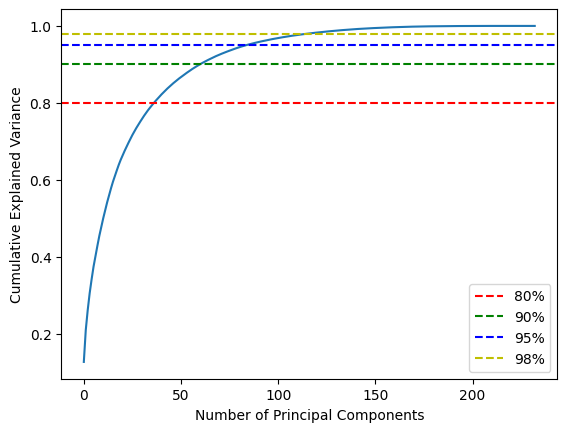

In [8]:
# LAB 4 --------------------------------
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Pentru a folosi PCA, nu putem avea valori NaN
# Imputer doar face media aritmetica la feature si umple NaN-urile
imputer = SimpleImputer(strategy='mean')
X_filled = imputer.fit_transform(X)

# Run the PCA process
pca = PCA()  
X_pca = pca.fit_transform(X_filled)

# Explained variance = how much variance each PC covers
explained = pca.explained_variance_ratio_
explained_understandableValues = np.round(explained, 3)
print('Explained variance ratio: ', explained_understandableValues[:10], " ...")

# Cumulative sum: ex. for explained = [0.6, 0.25, 0.1, 0.05], cumulative = [PC1, PC1+PC2, PC1+PC2+PC3, ...] = [0.6, 0.85, 0.95, 1.0]
cumulative = np.cumsum(explained)
print('Cumulative variance: ',cumulative[:5], " ...\n")

# Vedem cate componente sunt incluse pentru fiecare dintre procentaje
for variance in [0.98, 0.95, 0.90, 0.80]:
    cnt = np.argmax(cumulative >= variance) + 1
    print(f"{variance*100:.0f}% variance accumulated by {cnt} components")

plt.plot(cumulative)
plt.axhline(y=0.8, color='r', linestyle='--', label='80%')
plt.axhline(y=0.9, color='g', linestyle='--', label='90%')
plt.axhline(y=0.95, color='b', linestyle='--', label='95%')
plt.axhline(y=0.98, color='y', linestyle='--', label='98%')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.show()

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.1, random_state=42)

dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test)

model = xgb.train(best_params, dtrain, num_boost_round=100)

y_pred = model.predict(dtest)

y_pred = np.argmax(y_pred, axis=1)
print(f" Accuracy of prediction: {accuracy_score(Y_test, y_pred)}")

 Accuracy of prediction: 0.78839590443686


****************************
Initial-cluster model: random
Homogeneity: 0.176
Completeness: 0.154
Measuring: 0.164
Adjusted Random: 0.109
Adusted mutual info: 0.163
Silhouette: 0.082
****************************
Initial-cluster model: random
Homogeneity: 0.179
Completeness: 0.132
Measuring: 0.152
Adjusted Random: 0.093
Adusted mutual info: 0.150
Silhouette: 0.085


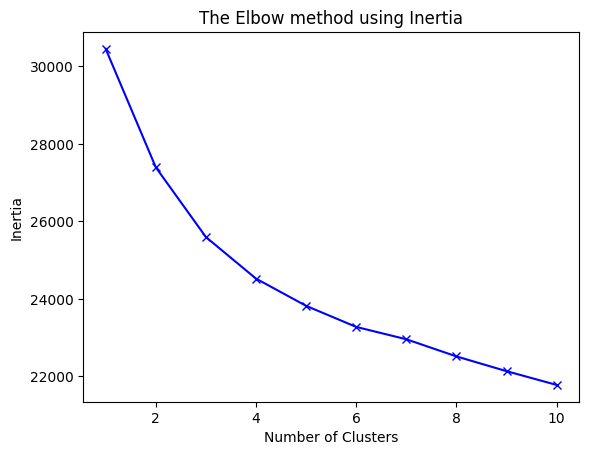

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from scipy.spatial.distance import cdist

def benchmark(model: KMeans, name: str, data):

    model.fit(data)
    print(f"Initial-cluster model: {name}")
    Y_arr = Y.iloc[:, 0].to_numpy()
    # !!! DE MODIFICAT CU MASURATORI CORESPUNZATOARE
    # HOMOGENEITY
    print(f"Homogeneity: {homogeneity_score(Y_arr, model.labels_):.3f}")
    # COMPLETNESS SCORE
    print(f"Completeness: {completeness_score(Y_arr, model.labels_):.3f}")
    # V-Measuring
    print(f"Measuring: {v_measure_score(Y_arr, model.labels_):.3f}")
    # Adjusted Random
    print(f"Adjusted Random: {adjusted_rand_score(Y_arr, model.labels_):.3f}")
    # Adjusted mutual info
    print(f"Adusted mutual info: {adjusted_mutual_info_score(Y_arr, model.labels_):.3f}")
    # Silhouette
    print(f"Silhouette: {silhouette_score(data, model.labels_):.3f}")
     

max_classes = 10
inertias = []

for no_classes in range(1, max_classes+1):
    kmeans_model = KMeans(init= "random", 
                          n_clusters=no_classes,
                          n_init=5, 
                          random_state=0)
    # within cluster sum of squares
    if no_classes == 5 or no_classes == 4:
        print("****************************")
        benchmark(kmeans_model, 'random', X_pca)
        inertias.append(kmeans_model.inertia_)
    else:
        kmeans_model.fit(X_pca)
        inertias.append(kmeans_model.inertia_)
# plotting the elbow method 
plt.plot(range(1, max_classes+1), inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow method using Inertia')
plt.show()

    


0.09672862548542638
0.08245258552864553
0.09036293731324008
0.08347685316874999


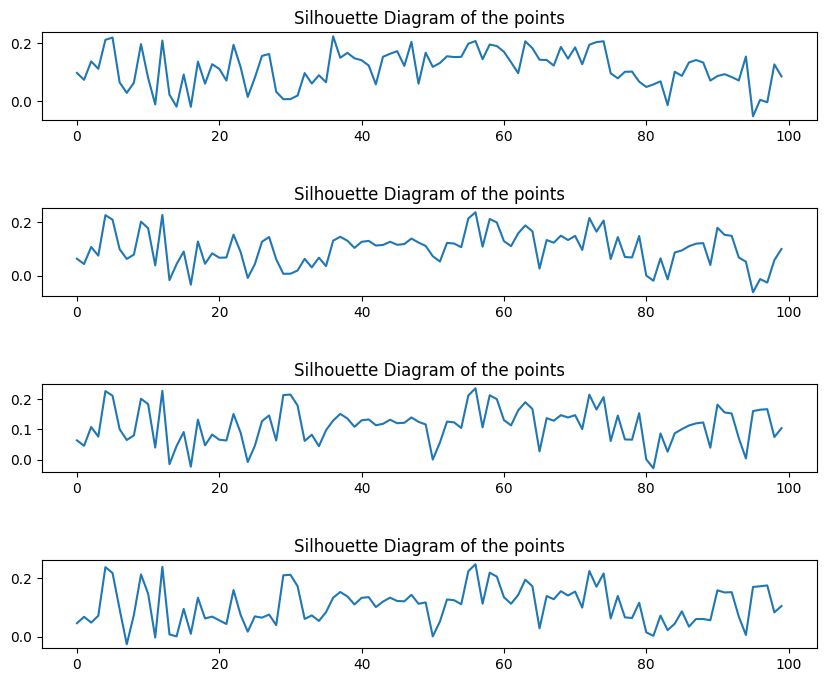

In [13]:
# Silhouette plotting 
from sklearn.metrics import silhouette_samples

fig, axis = plt.subplots(4, 1, figsize=(10, 8))
for k in range(3, 7):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model.fit(X_pca)
    data = silhouette_samples(X_pca, kmeans_model.labels_)
    avg_silhouette = silhouette_score(X_pca, kmeans_model.labels_)
    axis[k-3].plot(data[:100])
    axis[k-3].set_title('Silhouette Diagram of the points')
    print(avg_silhouette)
    
plt.subplots_adjust(wspace=0.4, hspace=1)
plt.show()

For n_clusters = 2, The average silhouette_score is : 0.096
For n_clusters = 3, The average silhouette_score is : 0.097
For n_clusters = 4, The average silhouette_score is : 0.082
For n_clusters = 5, The average silhouette_score is : 0.085
For n_clusters = 6, The average silhouette_score is : 0.083


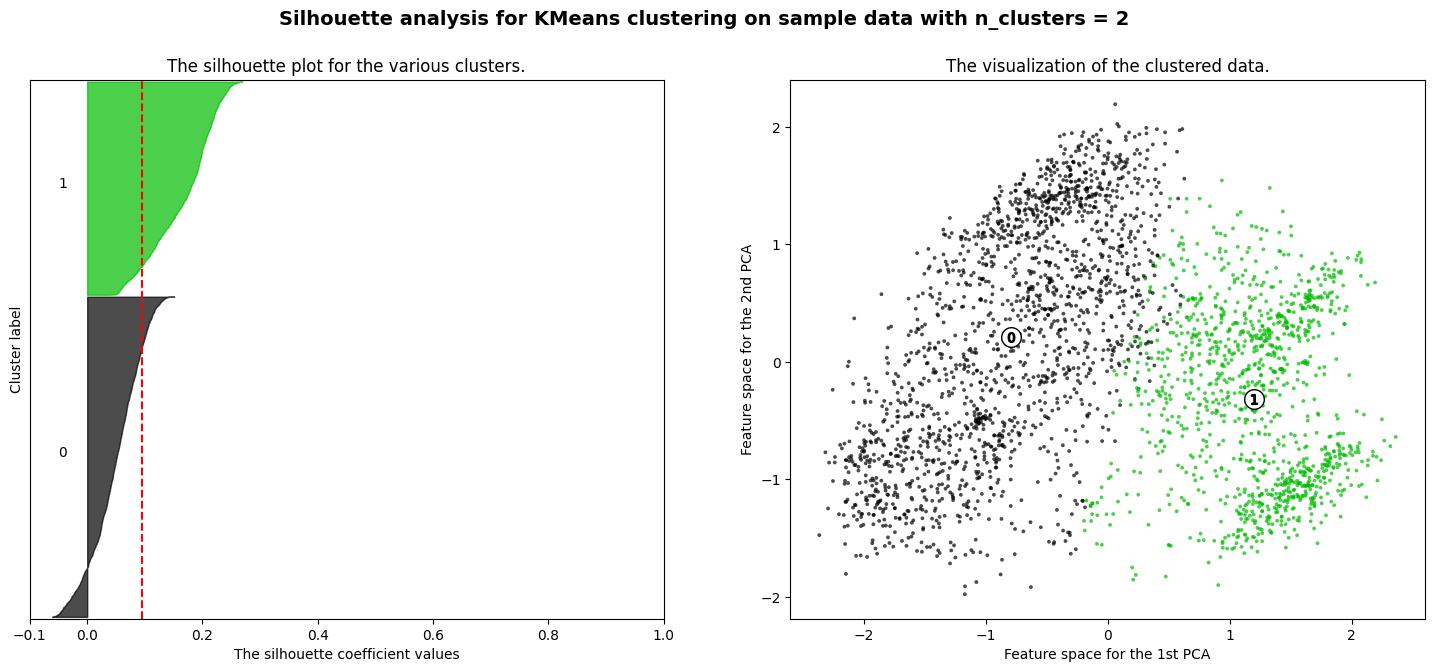

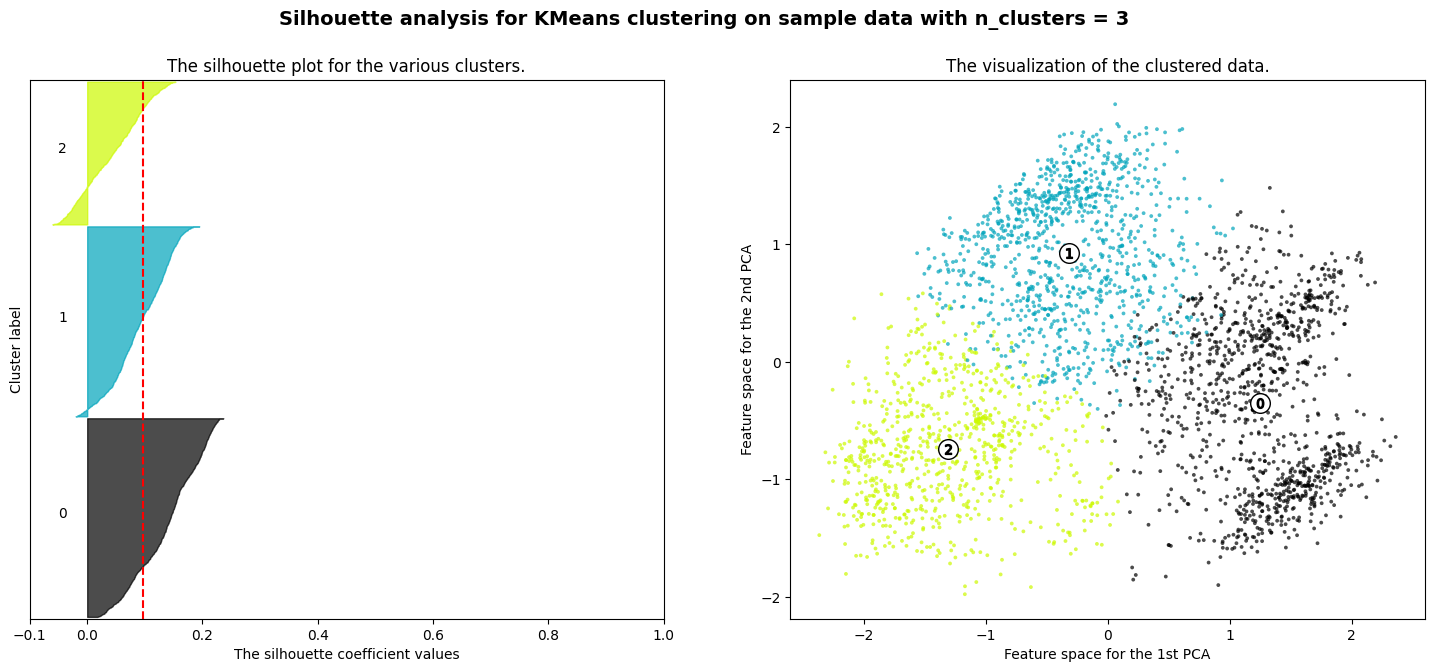

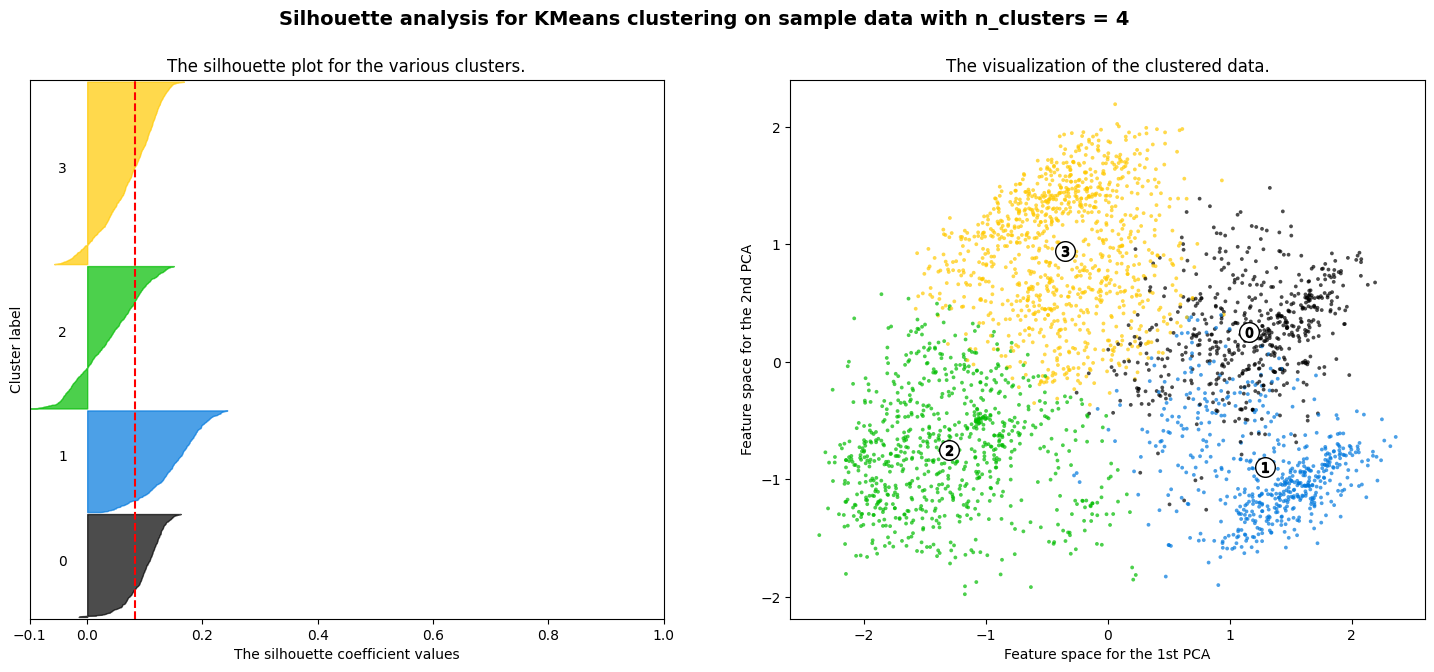

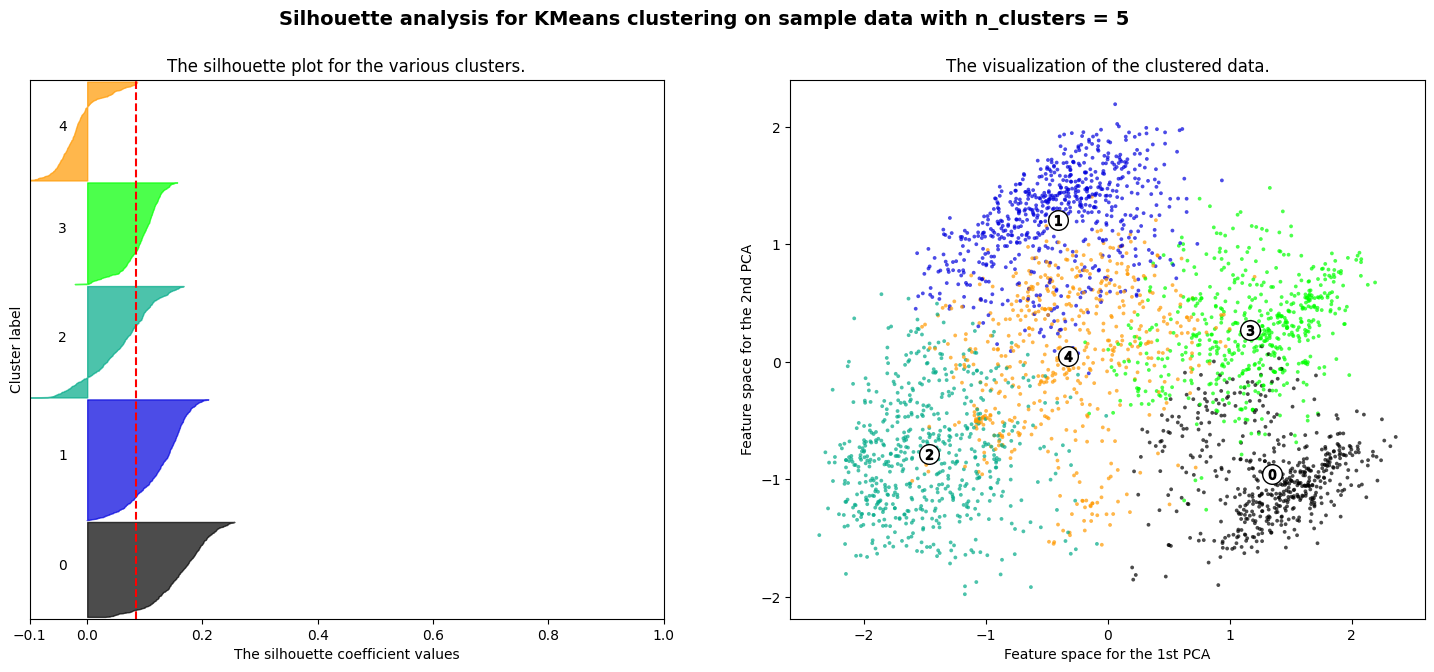

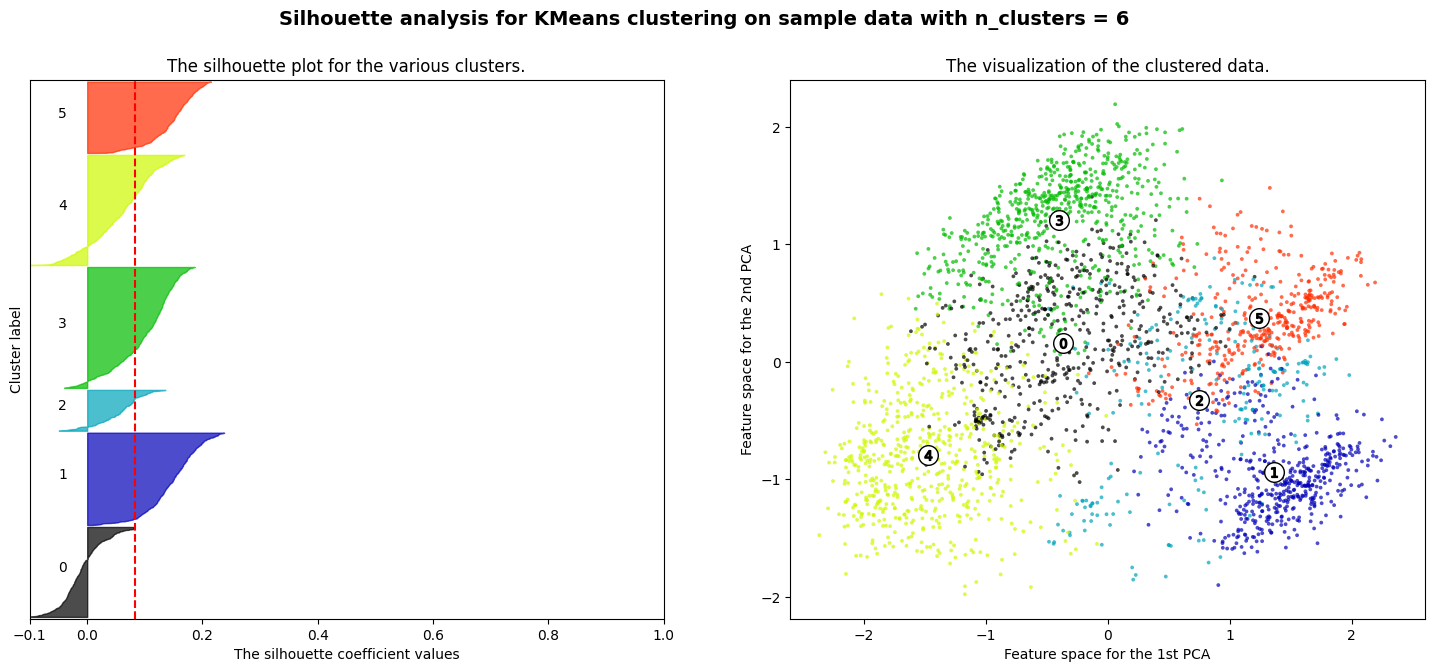

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score




range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg:.3f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        # This creates the solid "filled" shape
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # --- RIGHT PLOT: THE CLUSTERS ---
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    # Note: We take X[:, 0] and X[:, 1] (The first two PCA components)
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st PCA")
    ax2.set_ylabel("Feature space for the 2nd PCA")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [ ]:
# PCA 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

for no_comp in range(100, 200, 5):
    # X_filled = StandardScaler().fit_transform(X_filled)
    pca = PCA(n_components=no_comp)
    X_pca = pca.fit_transform(X_filled)
    print(f"Variance Ratio: {pca.explained_variance_ratio_}")
    sum_variance = np.cumsum(pca.explained_variance_ratio_)
    comps = np.argmax(sum_variance > .98) + 1
    
    print(f"Number of PCA components necesarry for the preservation of the dataset's variance up to 98%: {comps}")




Variance Ratio: [0.12736066 0.08273331 0.05184593 0.04357267 0.0360868  0.03324415
 0.02789928 0.0266928  0.02588815 0.02329878 0.02222222 0.02090531
 0.02007939 0.018875   0.0177722  0.01701164 0.01515544 0.0146514
 0.01436604 0.01288812 0.01172446 0.01131781 0.01078674 0.01047813
 0.01027671 0.00973995 0.00915323 0.00878048 0.00836795 0.0079863
 0.00791245 0.0076432  0.00724283 0.00696365 0.00650251 0.00630644
 0.00613138 0.00579859 0.00564987 0.00555628 0.00543625 0.00510405
 0.00504196 0.00497633 0.00463336 0.00454025 0.00445787 0.00419265
 0.00415578 0.00402176 0.00381852 0.00380042 0.00371505 0.00359433
 0.00356136 0.00341779 0.00340386 0.00325323 0.00311168 0.00299557
 0.00294989 0.00284784 0.00272715 0.00263237 0.00255762 0.00248439
 0.00243365 0.00240843 0.0023834  0.00221936 0.00212121 0.00210441
 0.00204787 0.00198726 0.00191923 0.00190362 0.0018863  0.00183726
 0.00173901 0.00171895 0.00167807 0.00162809 0.0015256  0.00145635
 0.00141099 0.00136317 0.00130873 0.0012689  0.0

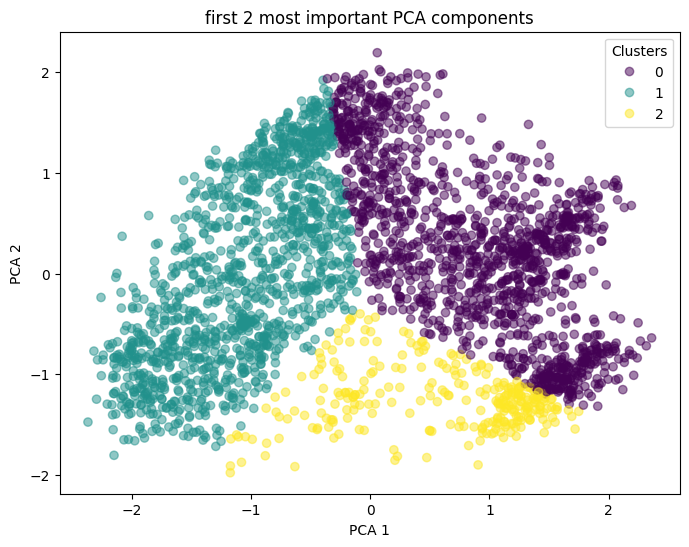

In [44]:
# plotting the first 2 imporant PCA components 

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt 

# declare the PCA components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filled)
# define the model
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(X_pca)

# plot the result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=.5)
plt.legend(*scatter.legend_elements(), title='Clusters')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('first 2 most important PCA components')
plt.show()


# Based on the number of PCA components the number of clusters are affected 
# for example even if I increase the number of clusters because I end up projecting onto just 2 PCA the clusters 
# wont pass the number of 3 
# Also by adding too many PCA components the model is uncapable to separate it anymore into clusters 

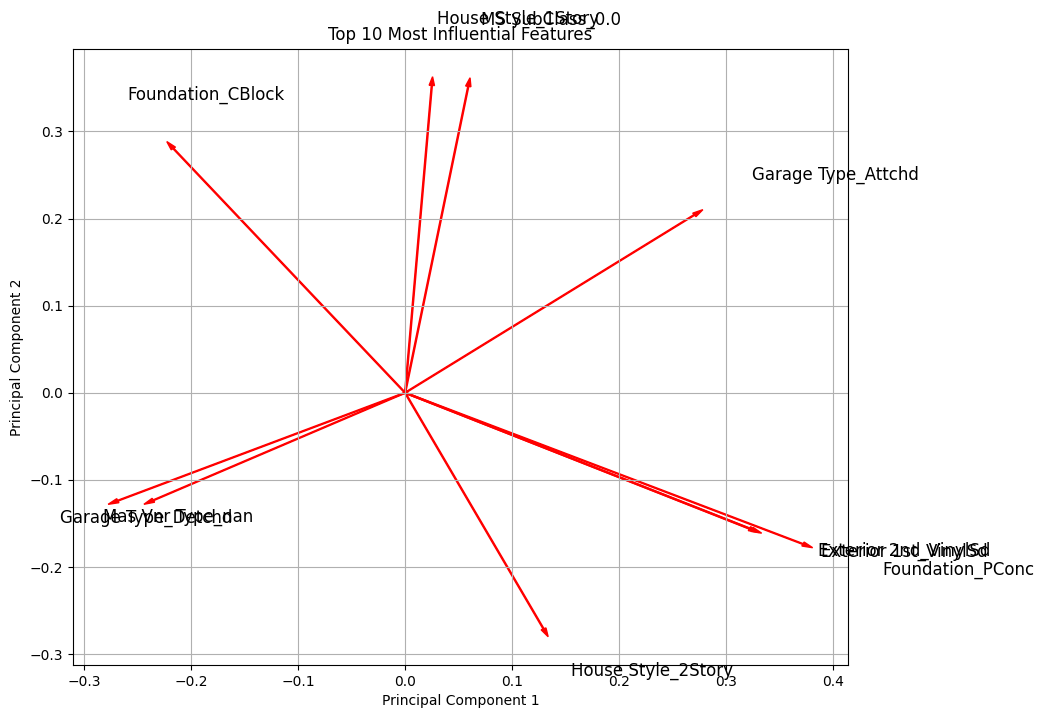

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


loadings = pca.components_.T * np.sqrt(pca.explained_variance_)


# We use this to find the "strongest" features, not just the first 10 alphabetical ones
magnitude = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)


top_indices = np.argsort(magnitude)[::-1][:10]

fig, ax = plt.subplots(figsize=(10, 8))
all_features = list(X.columns)

#
for i in top_indices:   
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
             head_width=0.005, head_length=0.01, fc='red', ec='red')
    
    
    ax.text(loadings[i, 0]*1.2, loadings[i, 1]*1.2, 
            all_features[i], color='black', fontsize=12)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title("Top 10 Most Influential Features")
ax.grid(True)

plt.show()

         SalePrice  Lot Area  Gr Liv Area  Yr Sold  Pool Area
Cluster                                                      
0         142112.5    9585.5       1231.0   2008.0        0.0
1         220000.0   10274.0       1776.0   2008.0        0.0
2         125000.0    8064.0       1324.0   2008.0        0.0
3         221900.0    9988.0       1564.5   2008.0        0.0
4         146000.0    2880.0       1250.0   2008.0        0.0
5         158000.0   10382.0       1336.0   2008.0        0.0


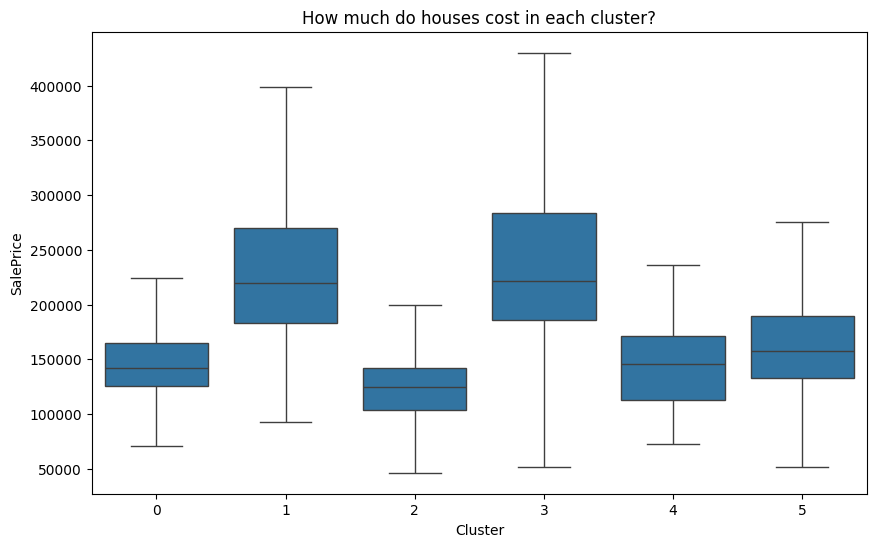

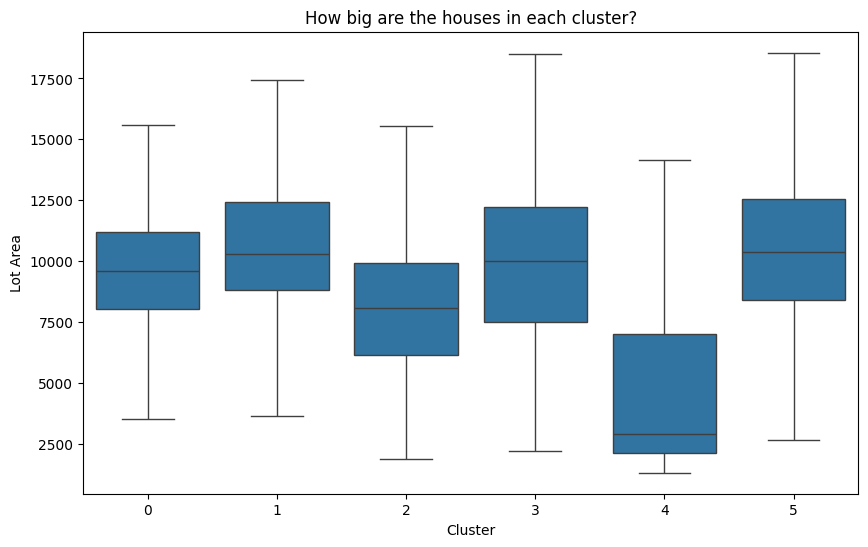

In [ ]:
#see what's inside of each cluster

localCopy_v2['Cluster'] = kmeans_model.labels_

columns_of_interest = ['SalePrice', 'Lot Area','Gr Liv Area','Yr Sold','Pool Area']


print(localCopy_v2.groupby('Cluster')[columns_of_interest].median())

plt.figure(figsize=(10,6))
sns.boxplot(x='Cluster', y='SalePrice', data=localCopy_v2,showfliers=False)
plt.title("How much do houses cost in each cluster?")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='Cluster', y='Lot Area', data=localCopy_v2,showfliers=False)
plt.title("How big are the houses in each cluster?")
plt.show()

In [ ]:
#logarithmic experiment


X_log = X.copy()
pt = PowerTransformer(method='yeo-johnson')
for col in X_log.columns:
    sk=skew(X_log[col],nan_policy='omit')
    if abs(sk)>2:
        print(f"Coloana: {col} - old skew:{sk}")
        pt.fit(X_log[[col]])
        X_log[col] = pt.transform(X_log[[col]])
        sk_new=skew(X_log[col],nan_policy='omit')
        print(f"New skewness: {sk_new}")

Coloana: Lot Area - old skew:12.921303469227427
New skewness: -0.10730170798193946
Coloana: Mas Vnr Area - old skew:2.603491982924755
New skewness: 0.7284418130641287
Coloana: BsmtFin Type 2 - old skew:3.3001381958283966
New skewness: 2.297268297478956
Coloana: BsmtFin SF 2 - old skew:4.13541032925794
New skewness: 2.38453176142963
Coloana: Low Qual Fin SF - old skew:12.103527135147237
New skewness: 8.376394004836184
Coloana: Bsmt Half Bath - old skew:3.93718133741119
New skewness: 3.712628884167142
Coloana: Kitchen AbvGr - old skew:4.30821400114301
New skewness: -2.995689082974603
Coloana: Functional - old skew:-5.168186171096897
New skewness: -3.3999093857232467
Coloana: Garage Qual - old skew:-2.1615430991318396
New skewness: 1.1749513416800035
Coloana: Garage Cond - old skew:-3.6488478556672854
New skewness: 2.0099055486387147
Coloana: Open Porch SF - old skew:2.5293333162812095
New skewness: 0.40959445165064534
Coloana: Enclosed Porch - old skew:4.0215428942506435
New skewness: 1.

In [42]:
kmeans_base = KMeans(n_clusters=5, n_init=10, random_state=42)


# Standardization
scaler_std=StandardScaler()
X_std = scaler_std.fit_transform(X_filled)

pca_std = PCA(n_components=1)
X_pca_std = pca_std.fit_transform(X_std)

benchmark(kmeans_base, "Experiment: Standardization", X_pca_std)


#Logarithmic

scaler_log=StandardScaler()
X_log_scaled = scaler_log.fit_transform(X_log)

imputer = SimpleImputer(strategy='mean')
X_log_scaled = imputer.fit_transform(X_log_scaled)
pca_log = PCA(n_components=1)
X_pca_log = pca_log.fit_transform(X_log_scaled)

benchmark(kmeans_base, "Experiment: Logarithmic", X_pca_log)

#Just because you kept 98% of the variance doesn't mean you kept the clusters. You might have kept the noise.

Initial-cluster model: Experiment: Standardization
Homogeneity: 0.334
Completeness: 0.252
Measuring: 0.287
Adjusted Random: 0.185
Adusted mutual info: 0.286
Silhouette: 0.536
Initial-cluster model: Experiment: Logarithmic
Homogeneity: 0.341
Completeness: 0.254
Measuring: 0.291
Adjusted Random: 0.202
Adusted mutual info: 0.290
Silhouette: 0.520


In [ ]:

indexOfTV2 = localCopy_v2.columns.get_loc("SalePrice")
X_v2 = localCopy_v2.iloc[:,:indexOfTV2]

In [ ]:

new_house = pd.DataFrame(X_v2.mean()).T
new_house.columns = X_v2.columns  


#check this part
#A Giant Luxury Mansion
new_house['Gr Liv Area'] = 4000  
new_house['Overall Qual'] = 10   
new_house['Year Built'] = 2024   
new_house['Lot Area'] = 20000    
new_house['Pool Area'] = 500     


new_house_scaled = scaler.transform(new_house)


new_house_pca = pca.transform(new_house_scaled)

predicted_cluster = kmeans_model.predict(new_house_pca)

print(f"------------------------------------------------")
print(f"The model put this house into Cluster: {predicted_cluster[0]}")
print(f"------------------------------------------------")

TypeError: can only concatenate str (not "int") to str